# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [217]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import randint

---
## 2. Load data

In [63]:
df = pd.read_csv('client_data.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [64]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [65]:
df_price = pd.read_csv('price_data.csv')
df_price["price_date"] = pd.to_datetime(df_price["price_date"], format='%Y-%m-%d')
df_price.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [ ]:
# Group off-peak prices by companies and month
monthly_price_by_id = df_price.groupby(['id', 'price_date']).agg({'price_peak_var': 'mean', 'price_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_peak_var': 'dec_1', 'price_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_peak_fix']
diff_peak = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff+peak.head()

In [126]:
df_price.head(1)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0


In [156]:
# Group off-peak prices by companies and month
monthly_price_by_id = df_price.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean','price_peak_var':'mean','price_mid_peak_var':'mean','price_peak_fix':'mean','price_mid_peak_fix':'mean'}).reset_index()
price_by_id = df_price.groupby(['id']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean','price_peak_var':'mean','price_mid_peak_var':'mean','price_peak_fix':'mean','price_mid_peak_fix':'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2','price_peak_var':'dec_3','price_mid_peak_var':'dec_4','price_peak_fix':'dec_5','price_mid_peak_fix':'dec_6'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff['peak_diff_dec_january_energy'] = diff['dec_3'] - diff['price_peak_var']
diff['midpeak_diff_dec_january_energy'] = diff['dec_4'] - diff['price_mid_peak_var']
diff['peak_diff_dec_january_power'] = diff['dec_5'] - diff['price_peak_fix']
diff['midpeak_diff_dec_january_power'] = diff['dec_6'] - diff['price_mid_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power',
       'peak_diff_dec_january_energy', 'midpeak_diff_dec_january_energy',
       'peak_diff_dec_january_power', 'midpeak_diff_dec_january_power']]

diff=diff.merge(price_by_id,how='inner',on='id')
diff.head(2)

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,midpeak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_power,price_off_peak_var,price_off_peak_fix,price_peak_var,price_mid_peak_var,price_peak_fix,price_mid_peak_fix
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916,-0.002302,0.003487,0.097749,0.065166,0.124338,40.701732,0.103794,0.07316,24.421038,16.280694
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779,0.000000,0.000000,0.000000,0.000000,0.146426,44.385450,0.000000,0.00000,0.000000,0.000000


In [157]:
diff=diff.merge(df[['id','churn']],how='inner',on='id')

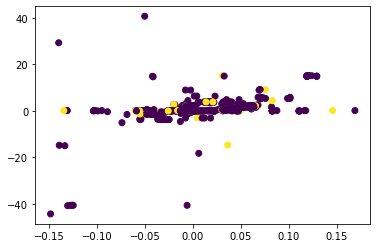

In [158]:
plt.scatter(diff['offpeak_diff_dec_january_energy'], diff['offpeak_diff_dec_january_power'],c=diff['churn'])

### Those 2 features alone might not be able to predict the churn as, its so overlapped

#### We can add more features which might differentiate the both

From the EDA Insights:
1.	Low consumption might be a lead:
    a.	The consumptions of the customers who are churning are lower. We could investigate those customers since they can easily switch into their vendors since they don’t need to change much of the infrastructure.
2.	Newer customers tend to leave:
    a.	The newer customers might tend to leave the company but already established customers are retained. 
3.	The margins for the customers who are churning are higher suggesting that the prices and profits from them are high. Discounts could be provided to retain them and won’t be big dent for the mean profits from the vendors

#### The Following Columns can be corporated as the first step:
1. cons_12m, cons_gas_12m, cons_last_month
2. num_years_antig
3. As we included the pricing, we can exclude the margins

In [163]:
df.columns

Index(['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn'],
      dtype='object')

In [164]:
diff=diff.merge(df[['id','cons_12m','cons_gas_12m','cons_last_month','num_years_antig','pow_max']],how='inner',on='id')

In [165]:
diff.head(2)

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,midpeak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_power,price_off_peak_var,price_off_peak_fix,price_peak_var,price_mid_peak_var,price_peak_fix,price_mid_peak_fix,churn,cons_12m,cons_gas_12m,cons_last_month,num_years_antig,pow_max
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916,-0.002302,0.003487,0.097749,0.065166,0.124338,40.701732,0.103794,0.07316,24.421038,16.280694,0,22034,0,3084,6,17.25
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779,0.000000,0.000000,0.000000,0.000000,0.146426,44.385450,0.000000,0.00000,0.000000,0.000000,0,4060,0,0,6,13.20


In [189]:
x_eng_cols = ['id', 'offpeak_diff_dec_january_energy',
       'offpeak_diff_dec_january_power', 'peak_diff_dec_january_energy',
       'midpeak_diff_dec_january_energy', 'peak_diff_dec_january_power',
       'midpeak_diff_dec_january_power', 'price_off_peak_var',
       'price_off_peak_fix', 'price_peak_var', 'price_mid_peak_var',
       'price_peak_fix', 'price_mid_peak_fix', 'cons_12m',
       'cons_gas_12m', 'cons_last_month', 'num_years_antig', 'pow_max']
y_col = 'churn'
X_train, X_test, y_train, y_test = train_test_split(
        diff[x_eng_cols], diff[y_col], test_size=0.2, stratify=diff[y_col], random_state=42
    )

In [206]:
def train_test_predict(X_train, x_cols):
    
    X_train_data = X_train[x_cols]
    scaler = StandardScaler()
    scaler.fit(X_train_data)

    X_train_scaled = scaler.transform(X_train_data)

    rf = RandomForestClassifier(n_estimators=100, random_state=143)

    cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=10,scoring='f1')


    return cv_scores


#### Iteration - Only Engineered features

In [207]:
x_cols = ['offpeak_diff_dec_january_energy',
       'offpeak_diff_dec_january_power']
cv_scores_eng= train_test_predict(X_train, x_cols)

In [208]:
print(cv_scores_eng.mean())
cv_scores_eng

0.03701805175233715


array([0.01526718, 0.05882353, 0.02985075, 0.04316547, 0.01626016,
       0.046875  , 0.03278689, 0.046875  , 0.04878049, 0.03149606])

##### Iteration-More features

In [209]:
x_eng_cols = ['offpeak_diff_dec_january_energy',
       'offpeak_diff_dec_january_power', 'cons_12m', 'cons_gas_12m',
       'cons_last_month', 'num_years_antig', 'pow_max']
cv_scores_eng= train_test_predict(X_train, x_eng_cols)

In [210]:
print(cv_scores_eng.mean())
cv_scores_eng

0.11372190866892082


array([0.2       , 0.11111111, 0.128     , 0.08196721, 0.12903226,
       0.08064516, 0.09917355, 0.144     , 0.08064516, 0.08264463])

### Iteration-Remaining Price

In [211]:
x_eng_cols=[ 'offpeak_diff_dec_january_energy',
       'offpeak_diff_dec_january_power', 'peak_diff_dec_january_energy',
       'midpeak_diff_dec_january_energy', 'peak_diff_dec_january_power',
       'midpeak_diff_dec_january_power', 'cons_12m', 'cons_gas_12m',
       'cons_last_month', 'num_years_antig', 'pow_max']
cv_scores_eng= train_test_predict(X_train, x_eng_cols)

In [212]:
print(cv_scores_eng.mean())
cv_scores_eng

0.1208228621199308


array([0.18181818, 0.125     , 0.128     , 0.08196721, 0.15384615,
       0.12403101, 0.09756098, 0.15267176, 0.08      , 0.08333333])

### My Features + Original Features

In [213]:
x_eng_cols=[ 'offpeak_diff_dec_january_energy',
       'offpeak_diff_dec_january_power', 'peak_diff_dec_january_energy',
       'midpeak_diff_dec_january_energy', 'peak_diff_dec_january_power',
       'midpeak_diff_dec_january_power', 'cons_12m', 'cons_gas_12m',
       'cons_last_month', 'num_years_antig', 'pow_max','price_off_peak_var',
       'price_off_peak_fix', 'price_peak_var', 'price_mid_peak_var',
       'price_peak_fix', 'price_mid_peak_fix']
cv_scores_eng= train_test_predict(X_train, x_eng_cols)

In [214]:
print(cv_scores_eng.mean())
cv_scores_eng

0.11920728224870777


array([0.21374046, 0.125     , 0.11023622, 0.112     , 0.13846154,
       0.0952381 , 0.11290323, 0.13846154, 0.07936508, 0.06666667])

### My Features

In [215]:
x_eng_cols=[ 'cons_12m', 'cons_gas_12m',
       'cons_last_month', 'num_years_antig', 'pow_max','price_off_peak_var',
       'price_off_peak_fix', 'price_peak_var', 'price_mid_peak_var',
       'price_peak_fix', 'price_mid_peak_fix']
cv_scores_eng= train_test_predict(X_train, x_eng_cols)

In [216]:
print(cv_scores_eng.mean())
cv_scores_eng

0.11354368279569893


array([0.203125  , 0.128     , 0.112     , 0.112     , 0.125     ,
       0.08064516, 0.1       , 0.128     , 0.08      , 0.06666667])

In [227]:
X_train_new = X_train[[ 'offpeak_diff_dec_january_energy',
       'offpeak_diff_dec_january_power', 'peak_diff_dec_january_energy',
       'midpeak_diff_dec_january_energy', 'peak_diff_dec_january_power',
       'midpeak_diff_dec_january_power', 'cons_12m', 'cons_gas_12m',
       'cons_last_month', 'num_years_antig', 'pow_max']]
X_test_new = X_test[[ 'offpeak_diff_dec_january_energy',
       'offpeak_diff_dec_january_power', 'peak_diff_dec_january_energy',
       'midpeak_diff_dec_january_energy', 'peak_diff_dec_january_power',
       'midpeak_diff_dec_january_power', 'cons_12m', 'cons_gas_12m',
       'cons_last_month', 'num_years_antig', 'pow_max']]

In [220]:
pipeline = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(random_state=42))
    ]
)

In [221]:
param_distributions = {
    'rf__n_estimators': randint(50, 200),
    'rf__max_depth': [None, 10, 20, 30, 40, 50],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2']
}

In [223]:
randomized_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='f1',
    random_state=42
)

randomized_search.fit(X_train_new, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=50,
                   param_distributions={'rf__max_depth': [None, 10, 20, 30, 40,
                                                          50],
                                        'rf__max_features': ['sqrt', 'log2'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000027C8E816760>},
                   random_state=42, scoring='f1')

In [224]:
best_estimator = randomized_search.best_estimator_
best_estimator.fit(X_train_new, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=50, max_features='log2',
                                        n_estimators=111, random_state=42))])

In [228]:
y_pred = best_estimator.predict(X_test_new)

test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)

In [229]:
test_scores = {
    'Test Precision': [test_precision],
    'Test Recall': [test_recall],
    'Test Accuracy': [test_accuracy]
}
test_scores_df = pd.DataFrame(test_scores, index=[0])

In [230]:
test_scores_df

,Test Precision,Test Recall,Test Accuracy
0,0.594595,0.077465,0.905202


### F1-score has been used to evaluate the model or tuning purposes due to the imbalanced data
### Moreover we could apply SMOTE and more advanced feature engineering like exponential importance to the prices could be experimented